### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework_2

Mounted at /gdrive
/gdrive/My Drive/Homework_2


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import regularizers
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [4]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

### Load data

In [5]:
dataset = np.load('training_data.npy')
print(dataset.shape)

(48000, 2776)


In [6]:
start_end_dataset = np.load('valid_periods.npy')
print(start_end_dataset.shape)

(48000, 2)


# Inspect Duplicates


In [7]:
def find_duplicate_indexes(dataset):
    seen_series = {}  # Dictionary to track series that have been seen
    duplicate_indexes = []  # List to store indexes of duplicated series

    for idx, series in enumerate(dataset):
        # Convert the series to a tuple for hashing (assuming series elements are hashable)
        series_tuple = tuple(series)

        if series_tuple not in seen_series:
            seen_series[series_tuple] = idx  # Store the index of the first occurrence
        else:
            # If a duplicate is found, add the current index to the list
            duplicate_indexes.append(idx)

    return duplicate_indexes

# Find and print the indexes of series that have duplicates
duplicate_indexes = find_duplicate_indexes(dataset)
print("Indexes of series with duplicates:", duplicate_indexes)

Indexes of series with duplicates: [2979, 6198, 17126, 17127, 27618, 34425, 34474, 34505, 34568, 36034, 36082, 36792, 37054, 42190, 42284, 42996, 43018, 43059, 43085, 43787, 44762, 45599, 46235, 46289, 46338, 46564]


In [8]:
len(duplicate_indexes)

26

In [9]:
def find_duplicate_series(dataset):
    unique_series = []  # List to store unique series
    duplicate_indices = []  # List to store the indexes of duplicated series
    seen_series = {}  # Dictionary to track series that have been seen

    for idx, series in enumerate(dataset):
        # Convert the series to a tuple for hashing (assuming series elements are hashable)
        series_tuple = tuple(series)

        if series_tuple not in seen_series:
            seen_series[series_tuple] = idx  # Store the index of the first occurrence
            unique_series.append(series)
        else:
            duplicate_indices.append((idx, seen_series[series_tuple]))  # Store both the current and first occurrence indexes

    return duplicate_indices

# Find and print the indexes of duplicated series
duplicate_indexes = find_duplicate_series(dataset)
print("Indexes of duplicated series:", duplicate_indexes)


Indexes of duplicated series: [(2979, 2973), (6198, 6191), (17126, 17124), (17127, 17122), (27618, 27617), (34425, 34389), (34474, 33257), (34505, 34504), (34568, 33421), (36034, 6802), (36082, 26714), (36792, 36768), (37054, 27255), (42190, 42175), (42284, 42277), (42996, 42654), (43018, 42963), (43059, 42958), (43085, 43055), (43787, 36029), (44762, 44756), (45599, 44934), (46235, 45340), (46289, 45368), (46338, 45387), (46564, 45513)]


In [12]:
dataset1 = pd.DataFrame(dataset)
start_end_dataset = pd.DataFrame(start_end_dataset)

In [13]:
# Extracting the first row from the first dataset
duplicate_example1 = dataset1.iloc[6198]

# Extracting the start and end positions from the second dataset for the time series
start_position = start_end_dataset.iloc[6198, 0]  # Assuming the start position is in the first column
end_position = start_end_dataset.iloc[6198, 1]  # Assuming the end position is in the second column

print(start_position, end_position)

# Extract the time series data using start and end positions
duplicate_example1_time_series = duplicate_example1[start_position:end_position]  # Adjust indexing as needed

print(len(duplicate_example1_time_series))

2720 2776
56


In [14]:
# Extracting the first row from the first dataset
duplicate_example2 = dataset1.iloc[6191]

# Extracting the start and end positions from the second dataset for the time series
start_position = start_end_dataset.iloc[6191, 0]  # Assuming the start position is in the first column
end_position = start_end_dataset.iloc[6191, 1]  # Assuming the end position is in the second column

print(start_position, end_position)

# Extract the time series data using start and end positions
duplicate_example2_time_series = duplicate_example2[start_position:end_position]  # Adjust indexing as needed

print(len(duplicate_example2_time_series))

2720 2776
56


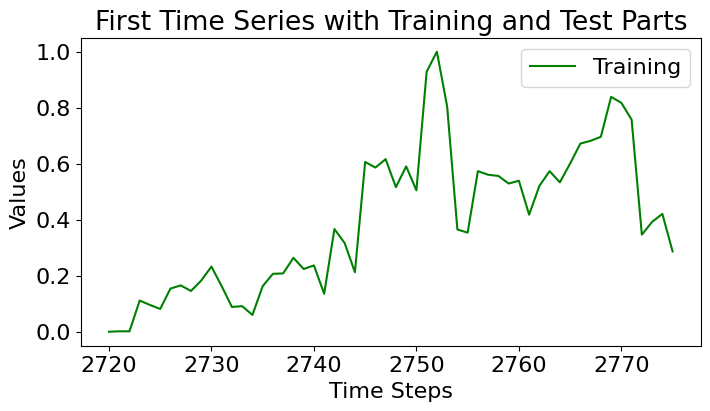

In [15]:
# Plotting the first row with different colors for training and test parts
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.plot(duplicate_example1_time_series, color='green', label='Training')  # Plot the data in green
plt.legend()
plt.title('First Time Series with Training and Test Parts')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()

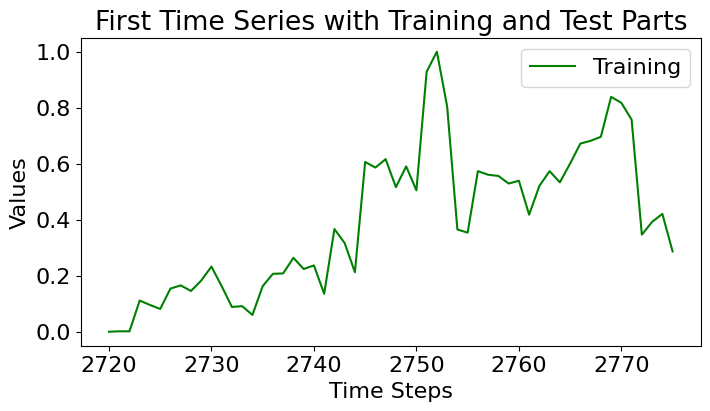

In [16]:
# Plotting the first row with different colors for training and test parts
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
plt.plot(duplicate_example2_time_series, color='green', label='Training')  # Plot the data in green
plt.legend()
plt.title('First Time Series with Training and Test Parts')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()

# Manage time series

In [18]:
start_end_dataset = np.load('valid_periods.npy')

In [19]:
# Initialize a list to store reshaped time series
reshaped_data = []

# Reshape the time series data
for i, (start, end) in enumerate(start_end_dataset):
    ts = dataset[i, start:end]  # Extracting the relevant portion of the time series
    reshaped_data.append(ts)

# Convert the list to a numpy array
reshaped_data = np.array(reshaped_data)

# reshaped_data.shape will be (48000, variable_length) without zero-padding


In [ ]:
first_time_series = reshaped_data[3]
print(first_time_series)
print(reshaped_data.shape)

[1.         0.92969871 0.6527977  0.67862267 0.57245337 0.59827834
 0.65710187 0.73888092 0.55810617 0.64131994 0.71736011 0.76327116
 0.68723099 0.82065997 0.63701578 0.6527977  0.74175036 0.67288379
 0.76183644 0.74031564 0.68579627 0.70301291 0.60114778 0.53084648
 0.51649928 0.55380201 0.6312769  0.54806313 0.52080344 0.51362984
 0.55810617 0.54375897 0.42898135 0.3543759  0.34289813 0.34289813
 0.41319943 0.55093257 0.4748924  0.4748924  0.50932568 0.28837877
 0.18077475 0.1276901  0.         0.13773314 0.12195122 0.21090387
 0.08177905 0.23959828 0.23098996 0.28407461 0.56814921 0.517934
 0.41176471 0.30703013 0.32568149 0.3615495  0.43041607 0.48637016
 0.45050215 0.47058824 0.56958393 0.57101865]
(48000,)


In [20]:
train_percentage = 0.8  # Define your train percentage here

train_data = []
test_data = []

# Perform train-test split for each series
for series in reshaped_data:
    series_length = len(series)
    split_index = int(series_length * train_percentage)

    # Split the series into train and test segments
    train_segment = series[:split_index]
    test_segment = series[split_index:]

    train_data.append(train_segment)
    test_data.append(test_segment)

# Convert lists to numpy arrays
train_data = np.array(train_data)
test_data = np.array(test_data)

# Check the shapes of the train and test data for a sample
print("Train data shape for a sample series:", train_data.shape)
print("Test data shape for a sample series:", test_data.shape)


Train data shape for a sample series: (48000,)
Test data shape for a sample series: (48000,)


In [21]:
def create_sequences(series, window=200, stride=5, telescope=9):
    sequences = []
    labels = []

    padding_check = len(series) % window
    if padding_check != 0:
        # Compute padding length
        padding_len = window - padding_check
        padding = np.zeros(padding_len, dtype='float32')
        series = np.concatenate((series, padding), axis=0)
        assert len(series) % window == 0

    for i in range(0, len(series) - window - telescope + 1, stride):
        sequence = series[i:i + window]
        label = series[i + window:i + window + telescope]
        sequences.append(sequence)
        labels.append(label)

    return np.array(sequences), np.array(labels)

In [22]:
train_sequences = []
train_labels = []

window_size = 200  # Define your window size
stride = 5  # Define your stride
telescope = 18  # Define your telescope

for series in train_data:
    sequences, labels = create_sequences(series, window=window_size, stride=stride, telescope=telescope)
    train_sequences.extend(sequences)
    train_labels.extend(labels)

train_sequences = np.array(train_sequences)
train_labels = np.array(train_labels)

print("Train sequences shape:", train_sequences.shape)
print("Train labels shape:", train_labels.shape)

Train sequences shape: (745513, 200)
Train labels shape: (745513, 9)


In [ ]:
train_sequences_reshaped = train_sequences.reshape(train_sequences.shape[0], train_sequences.shape[1], 1)
train_labels_reshaped = train_labels.reshape(train_labels.shape[0], train_labels.shape[1], 1)

print("Train sequences shape after reshaping:", train_sequences_reshaped.shape)
print("Train labels shape after reshaping:", train_labels_reshaped.shape)

Train sequences shape after reshaping: (745513, 200, 1)
Train labels shape after reshaping: (745513, 9, 1)


In [ ]:
test_sequences = []
test_labels = []

# Creating sequences for each series in the test data
for series in test_data:
    sequences, labels = create_sequences(series, window=window_size, stride=stride, telescope=telescope)
    test_sequences.extend(sequences)
    test_labels.extend(labels)

test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)

print("Test sequences shape:", test_sequences.shape)
print("Test labels shape:", test_labels.shape)

Test sequences shape: (1995, 200)
Test labels shape: (1995, 9)


# Model

In [ ]:
input_shape = train_sequences_reshaped.shape[1:]
output_shape = train_labels_reshaped.shape[1:]
batch_size = 512
epochs = 200

In [ ]:
print(input_shape)
print(output_shape)

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Model definition
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # LSTM Layer with optimized number of units
    lstm_out = tfkl.Bidirectional(tfkl.LSTM(48, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Attention Layer (optional based on performance impact)
    attention = tfkl.Attention(name='attention_layer')([lstm_out, lstm_out])
    x = tfkl.Concatenate(name='concatenate_layer')([lstm_out, attention])

    # Convolutional Layer with adjusted filters and regularization
    x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv')(x)

    x = tfkl.Flatten()(x)

    # Dense Output Layer with adjusted regularizer
    output_layer = tfkl.Dense(output_shape[0] * output_shape[1])(x)

    # Construct the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model_optimized')

    # Compile the model with adjusted learning rate
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model


Model: "CONV_LSTM_model_optimized"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 96)              19200     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 attention_layer (Attention  (None, 200, 96)              0         ['bidirectional_lstm[0][0]',  
 )                                                                   'bidirectional_lstm[0][0]']  
                                                                          

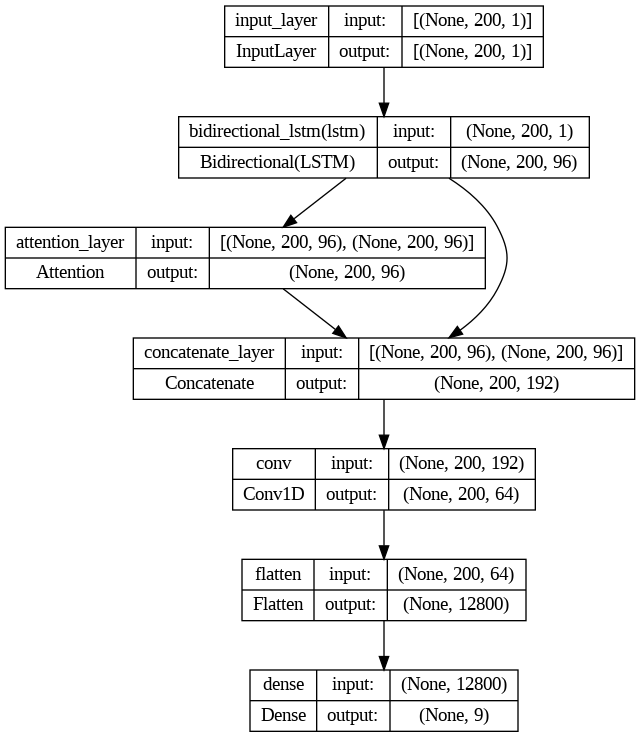

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = train_sequences_reshaped,
    y = train_labels_reshaped,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
1165/1165 [==============================] - 48s 36ms/step - loss: 0.0120 - val_loss: 0.0103 - lr: 0.0010
Epoch 2/200
1165/1165 [==============================] - 42s 36ms/step - loss: 0.0100 - val_loss: 0.0100 - lr: 0.0010
Epoch 3/200
1165/1165 [==============================] - 43s 37ms/step - loss: 0.0091 - val_loss: 0.0103 - lr: 0.0010
Epoch 4/200
1165/1165 [==============================] - 41s 35ms/step - loss: 0.0084 - val_loss: 0.0095 - lr: 0.0010
Epoch 5/200
1165/1165 [==============================] - 41s 36ms/step - loss: 0.0080 - val_loss: 0.0092 - lr: 0.0010
Epoch 6/200
1165/1165 [==============================] - 41s 35ms/step - loss: 0.0077 - val_loss: 0.0093 - lr: 0.0010
Epoch 7/200
1165/1165 [==============================] - 41s 35ms/step - loss: 0.0074 - val_loss: 0.0099 - lr: 0.0010
Epoch 8/200
1165/1165 [==============================] - 42s 36ms/step - loss: 0.0073 - val_loss: 0.0091 - lr: 0.0010
Epoch 9/200
1165/1165 [==============================] -

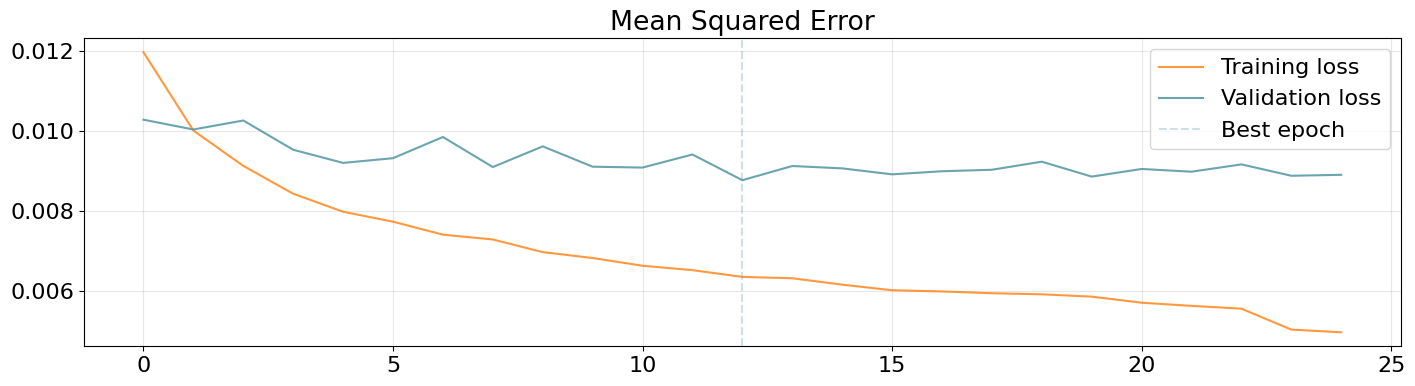

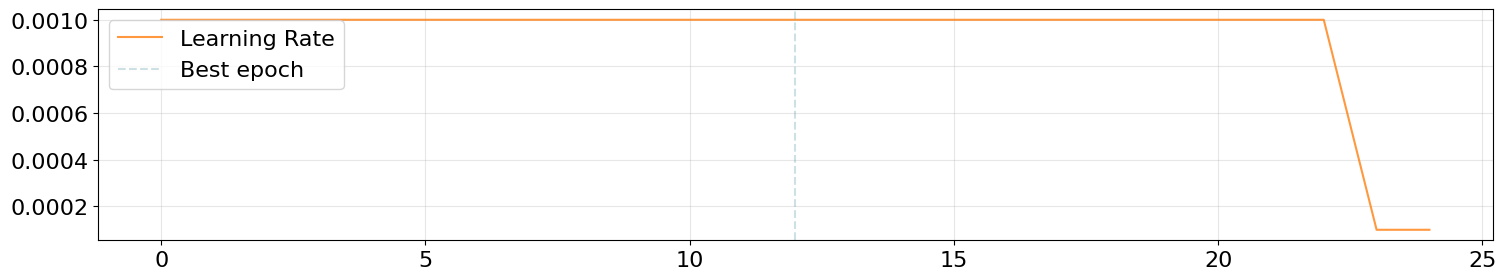

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('change_approach_with_attention')
model = tfk.models.load_model('change_approach_with_attention')

Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(test_sequences, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(test_labels.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(test_labels.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (1995, 9)
Mean Squared Error: 0.014366074465215206
Mean Absolute Error: 0.04579150676727295
